Unzip folder

In [1]:
!tar -xvf /content/drive/My\ Drive/Task02_Heart.tar

Task02_Heart/._dataset.json
Task02_Heart/dataset.json
Task02_Heart/._imagesTr
Task02_Heart/imagesTr/
Task02_Heart/imagesTr/la_007.nii.gz
Task02_Heart/imagesTr/la_019.nii.gz
Task02_Heart/imagesTr/la_023.nii.gz
Task02_Heart/imagesTr/la_005.nii.gz
Task02_Heart/imagesTr/la_009.nii.gz
Task02_Heart/imagesTr/la_017.nii.gz
Task02_Heart/imagesTr/la_021.nii.gz
Task02_Heart/imagesTr/._la_029.nii.gz
Task02_Heart/imagesTr/la_029.nii.gz
Task02_Heart/imagesTr/la_003.nii.gz
Task02_Heart/imagesTr/la_011.nii.gz
Task02_Heart/imagesTr/la_030.nii.gz
Task02_Heart/imagesTr/la_022.nii.gz
Task02_Heart/imagesTr/la_014.nii.gz
Task02_Heart/imagesTr/la_018.nii.gz
Task02_Heart/imagesTr/la_020.nii.gz
Task02_Heart/imagesTr/la_004.nii.gz
Task02_Heart/imagesTr/la_016.nii.gz
Task02_Heart/imagesTr/la_024.nii.gz
Task02_Heart/imagesTr/la_010.nii.gz
Task02_Heart/imagesTr/la_026.nii.gz
Task02_Heart/._imagesTs
Task02_Heart/imagesTs/
Task02_Heart/imagesTs/la_015.nii.gz
Task02_Heart/imagesTs/la_025.nii.gz
Task02_Heart/imagesTs/

Install necessary libraries

In [2]:
!pip3 install numpy matplotlib scikit-learn
!pip3 install torch torchvision 
!pip3 install medicaltorch
!pip3 install tqdm

Import packages used

In [3]:
import os
import glob
import time
from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
from torch import optim
from torchvision.transforms import Compose
import torchvision.utils as vutils

from medicaltorch.datasets import SegmentationPair2D, MRI2DSegmentationDataset, mt_collate
from medicaltorch.transforms import ToTensor, Resample, ElasticTransform, CenterCrop2D, RandomAffine, RandomTensorChannelShift, NormalizeInstance
from medicaltorch.models import Unet
from medicaltorch import metrics as mt_metrics
from medicaltorch import losses as mt_losses

In [4]:
ROOT_DIR = '/content/Task02_Heart'

In [5]:
input_filename = os.path.join(ROOT_DIR, 'imagesTr', 'la_010.nii.gz')
gt_filename = os.path.join(ROOT_DIR, 'labelsTr', 'la_010.nii.gz')
pair = SegmentationPair2D(input_filename, gt_filename)
pair.get_pair_shapes()

((320, 320, 120), (320, 320, 120))

Example slice

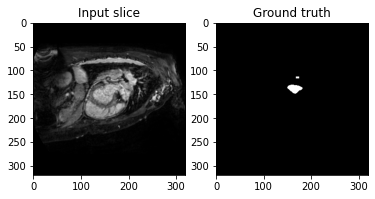

In [6]:
slice_pair = pair.get_pair_slice(42)
input = slice_pair['input']
gt = slice_pair['gt']

plt.subplot(1, 2, 1)
plt.imshow(input, cmap='gray')
plt.title('Input slice')

plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='gray')
plt.title('Ground truth')

plt.show()

In [7]:
!ls -a /content/Task02_Heart/imagesTr/

.	       la_007.nii.gz  la_016.nii.gz  la_021.nii.gz  ._la_029.nii.gz
..	       la_009.nii.gz  la_017.nii.gz  la_022.nii.gz  la_029.nii.gz
la_003.nii.gz  la_010.nii.gz  la_018.nii.gz  la_023.nii.gz  la_030.nii.gz
la_004.nii.gz  la_011.nii.gz  la_019.nii.gz  la_024.nii.gz
la_005.nii.gz  la_014.nii.gz  la_020.nii.gz  la_026.nii.gz


Delete metadata files

In [8]:
!rm -rf /content/Task02_Heart/imagesTr/.*
!rm -rf /content/Task02_Heart/imagesTs/.*
!rm -rf /content/Task02_Heart/labelsTr/.*

rm: refusing to remove '.' or '..' directory: skipping '/content/Task02_Heart/imagesTr/.'
rm: refusing to remove '.' or '..' directory: skipping '/content/Task02_Heart/imagesTr/..'
rm: refusing to remove '.' or '..' directory: skipping '/content/Task02_Heart/imagesTs/.'
rm: refusing to remove '.' or '..' directory: skipping '/content/Task02_Heart/imagesTs/..'
rm: refusing to remove '.' or '..' directory: skipping '/content/Task02_Heart/labelsTr/.'
rm: refusing to remove '.' or '..' directory: skipping '/content/Task02_Heart/labelsTr/..'


Create dataset given file names

In [9]:
img_list = glob.glob(os.path.join(ROOT_DIR, 'imagesTr/')+'*.gz')
label_list = glob.glob(os.path.join(ROOT_DIR, 'labelsTr/')+'*.gz')

filename_pairs = [(os.path.join(ROOT_DIR, 'imagesTr', x), os.path.join(ROOT_DIR, 'labelsTr', y)) for x, y in zip(img_list, label_list)]
train_dataset = MRI2DSegmentationDataset(filename_pairs, transform=ToTensor())

Thresholding function to convert output to either 0 or 1

In [81]:
def threshold_preds(preds, thr=0.999):
    preds = preds[:]
    ind = preds < thr
    preds[ind] = 0
    ind = (preds >= thr)
    preds[ind] = 1
    return preds

Transforms to enhance training

In [82]:
train_transform = Compose([
        ElasticTransform(alpha_range=(28.0, 30.0),
                                       sigma_range=(3.5, 4.0),
                                       p=0.3),
        RandomAffine(degrees=4.6,
                                   scale=(0.98, 1.02),
                                   translate=(0.03, 0.03)),
        RandomTensorChannelShift((-0.10, 0.10)),
        ToTensor(),
        NormalizeInstance(),
])

val_transform = Compose([
        ToTensor(),
        NormalizeInstance(),
])

Create train and validation sets

In [83]:
pairs = [(os.path.join(ROOT_DIR, 'imagesTr', x), os.path.join(ROOT_DIR, 'labelsTr', y)) for x, y in zip(img_list, label_list)]
train_pairs, val_pairs = train_test_split(pairs, test_size=0.2)
train_dataset = MRI2DSegmentationDataset(train_pairs, transform=train_transform)
val_dataset = MRI2DSegmentationDataset(val_pairs, transform=val_transform)

Dataloaders

In [87]:
train_loader = DataLoader(train_dataset, batch_size=16,
                          shuffle=True, pin_memory=False,
                          collate_fn=mt_collate,
                          num_workers=0)

val_loader = DataLoader(val_dataset, batch_size=16,
                        shuffle=True, pin_memory=False,
                        collate_fn=mt_collate,
                        num_workers=0)

Using a UNet with the Adam optimizer and scheduling the learning rate

In [88]:
model = Unet()
model.cuda()
epochs = 50
initial_lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

Training loop

In [89]:
torch.autograd.set_detect_anomaly(True)

train_dice_loss = []
val_dice_loss = []

for epoch in tqdm(range(1, epochs+1)):

    model.train()
    train_loss_total = 0.0
    num_steps = 0
    
    ### Train
    for i, batch in enumerate(train_loader):
        input_samples, gt_samples = batch["input"], batch["gt"]

        train_input = input_samples.cuda()
        train_gt = gt_samples.cuda(async=True)

        train_preds = model(train_input)

        loss = mt_losses.dice_loss(train_preds, train_gt)
        train_loss_total += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_steps += 1
    
    train_loss_total_avg = train_loss_total / num_steps
    train_acc  = mt_metrics.accuracy_score(train_preds.cpu().detach().numpy(), 
                          train_gt.cpu().detach().numpy())
    
    model.eval()
    val_loss_total = 0.0
    num_steps = 0
            
    ### Validate
    for i, batch in enumerate(val_loader):
        input_samples, gt_samples = batch["input"], batch["gt"]

        with torch.no_grad():
            val_input = input_samples.cuda()
            val_gt = gt_samples.cuda(async=True)

            val_preds = model(val_input)
            loss = mt_losses.dice_loss(val_preds, val_gt)
            val_loss_total += loss.item()

        val_gt_npy = gt_samples.numpy().astype(np.uint8)
        val_gt_npy = val_gt_npy.squeeze(axis=1)

        val_preds = val_preds.data.cpu().numpy()
        val_preds = threshold_preds(val_preds)
        val_preds = val_preds.astype(np.uint8)
        val_preds = val_preds.squeeze(axis=1)

        num_steps += 1

    val_acc  = mt_metrics.accuracy_score(val_preds, val_gt_npy)
    val_loss_total_avg = val_loss_total / num_steps
   
    scheduler.step()

    train_dice_loss.append(train_loss_total_avg)
    val_dice_loss.append(val_loss_total_avg)

    print('\nTrain loss: {:.4f}, Training Accuracy: {:.4f} '.format(train_loss_total_avg, train_acc))
    print('Val Loss: {:.4f}, Validation Accuracy: {:.4f} '.format(val_loss_total_avg, val_acc))

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  2%|▏         | 1/50 [02:11<1:47:46, 131.97s/it]


Train loss: -0.1145, Training Accuracy: 3.7804 
Val Loss: -0.2118, Validation Accuracy: 98.3721 


  4%|▍         | 2/50 [04:16<1:43:51, 129.82s/it]


Train loss: -0.2819, Training Accuracy: 28.5920 
Val Loss: -0.3942, Validation Accuracy: 99.3164 


  6%|▌         | 3/50 [06:21<1:40:29, 128.28s/it]


Train loss: -0.4020, Training Accuracy: 49.7962 
Val Loss: -0.5081, Validation Accuracy: 99.2588 


  8%|▊         | 4/50 [08:25<1:37:28, 127.14s/it]


Train loss: -0.4762, Training Accuracy: 58.7204 
Val Loss: -0.5033, Validation Accuracy: 99.4316 


 10%|█         | 5/50 [10:29<1:34:37, 126.16s/it]


Train loss: -0.5294, Training Accuracy: 78.5391 
Val Loss: -0.5539, Validation Accuracy: 99.4473 


 12%|█▏        | 6/50 [12:34<1:32:17, 125.84s/it]


Train loss: -0.5722, Training Accuracy: 57.8549 
Val Loss: -0.6305, Validation Accuracy: 100.0000 


 14%|█▍        | 7/50 [14:39<1:29:54, 125.44s/it]


Train loss: -0.6105, Training Accuracy: 80.1949 
Val Loss: -0.6678, Validation Accuracy: 100.0000 


 16%|█▌        | 8/50 [16:43<1:27:28, 124.96s/it]


Train loss: -0.6384, Training Accuracy: 84.0793 
Val Loss: -0.6854, Validation Accuracy: 99.8926 


 18%|█▊        | 9/50 [18:48<1:25:28, 125.07s/it]


Train loss: -0.6893, Training Accuracy: 80.3902 
Val Loss: -0.5722, Validation Accuracy: 99.3955 


 20%|██        | 10/50 [20:52<1:23:09, 124.74s/it]


Train loss: -0.7153, Training Accuracy: 77.5816 
Val Loss: -0.7479, Validation Accuracy: 99.9541 


 22%|██▏       | 11/50 [22:56<1:20:50, 124.38s/it]


Train loss: -0.7107, Training Accuracy: 93.6481 
Val Loss: -0.7930, Validation Accuracy: 99.9258 


 24%|██▍       | 12/50 [25:01<1:18:58, 124.70s/it]


Train loss: -0.7125, Training Accuracy: 84.4763 
Val Loss: -0.7685, Validation Accuracy: 100.0000 


 26%|██▌       | 13/50 [27:06<1:16:57, 124.80s/it]


Train loss: -0.7363, Training Accuracy: 82.5597 
Val Loss: -0.7152, Validation Accuracy: 99.2617 


 28%|██▊       | 14/50 [29:11<1:14:57, 124.93s/it]


Train loss: -0.7686, Training Accuracy: 89.0544 
Val Loss: -0.7548, Validation Accuracy: 100.0000 


 30%|███       | 15/50 [31:17<1:12:55, 125.03s/it]


Train loss: -0.7718, Training Accuracy: 93.3036 
Val Loss: -0.7969, Validation Accuracy: 99.9141 


 32%|███▏      | 16/50 [33:22<1:10:59, 125.28s/it]


Train loss: -0.7932, Training Accuracy: 82.5714 
Val Loss: -0.8058, Validation Accuracy: 99.9229 


 34%|███▍      | 17/50 [35:28<1:08:58, 125.40s/it]


Train loss: -0.7816, Training Accuracy: 88.1292 
Val Loss: -0.7938, Validation Accuracy: 99.8838 


 36%|███▌      | 18/50 [37:34<1:06:56, 125.52s/it]


Train loss: -0.7933, Training Accuracy: 94.8635 
Val Loss: -0.7923, Validation Accuracy: 100.0000 


 38%|███▊      | 19/50 [39:38<1:04:40, 125.18s/it]


Train loss: -0.7953, Training Accuracy: 70.9157 
Val Loss: -0.7812, Validation Accuracy: 99.8936 


 40%|████      | 20/50 [41:42<1:02:24, 124.83s/it]


Train loss: -0.7875, Training Accuracy: 88.6330 
Val Loss: -0.8344, Validation Accuracy: 99.9766 


 42%|████▏     | 21/50 [43:48<1:00:25, 125.02s/it]


Train loss: -0.8104, Training Accuracy: 76.9685 
Val Loss: -0.8126, Validation Accuracy: 99.8320 


 44%|████▍     | 22/50 [45:54<58:26, 125.24s/it]  


Train loss: -0.8226, Training Accuracy: 84.8399 
Val Loss: -0.8175, Validation Accuracy: 100.0000 


 46%|████▌     | 23/50 [47:59<56:24, 125.34s/it]


Train loss: -0.8223, Training Accuracy: 93.9410 
Val Loss: -0.8104, Validation Accuracy: 99.8428 


 48%|████▊     | 24/50 [50:04<54:17, 125.28s/it]


Train loss: -0.8238, Training Accuracy: 93.6068 
Val Loss: -0.8465, Validation Accuracy: 99.9414 


 50%|█████     | 25/50 [52:09<52:05, 125.02s/it]


Train loss: -0.8372, Training Accuracy: 89.7695 
Val Loss: -0.7960, Validation Accuracy: 100.0000 


 52%|█████▏    | 26/50 [54:14<50:02, 125.10s/it]


Train loss: -0.8360, Training Accuracy: 93.0430 
Val Loss: -0.8117, Validation Accuracy: 99.7305 


 54%|█████▍    | 27/50 [56:19<47:55, 125.03s/it]


Train loss: -0.8419, Training Accuracy: 95.7228 
Val Loss: -0.8337, Validation Accuracy: 100.0000 


 56%|█████▌    | 28/50 [58:23<45:45, 124.79s/it]


Train loss: -0.8394, Training Accuracy: 90.8487 
Val Loss: -0.8308, Validation Accuracy: 100.0000 


 58%|█████▊    | 29/50 [1:00:28<43:39, 124.74s/it]


Train loss: -0.8471, Training Accuracy: 93.5839 
Val Loss: -0.8566, Validation Accuracy: 99.8525 


 60%|██████    | 30/50 [1:02:31<41:23, 124.19s/it]


Train loss: -0.8466, Training Accuracy: 89.9138 
Val Loss: -0.8198, Validation Accuracy: 100.0000 


 62%|██████▏   | 31/50 [1:04:34<39:17, 124.09s/it]


Train loss: -0.8474, Training Accuracy: 89.4780 
Val Loss: -0.8117, Validation Accuracy: 99.8672 


 64%|██████▍   | 32/50 [1:06:38<37:08, 123.83s/it]


Train loss: -0.8533, Training Accuracy: 88.7608 
Val Loss: -0.8293, Validation Accuracy: 100.0000 


 66%|██████▌   | 33/50 [1:08:42<35:05, 123.88s/it]


Train loss: -0.8480, Training Accuracy: 90.3094 
Val Loss: -0.8412, Validation Accuracy: 100.0000 


 68%|██████▊   | 34/50 [1:10:45<33:01, 123.82s/it]


Train loss: -0.8527, Training Accuracy: 92.9939 
Val Loss: -0.8497, Validation Accuracy: 99.8750 


 70%|███████   | 35/50 [1:12:48<30:50, 123.35s/it]


Train loss: -0.8539, Training Accuracy: 89.2399 
Val Loss: -0.8425, Validation Accuracy: 99.9004 


 72%|███████▏  | 36/50 [1:14:51<28:45, 123.23s/it]


Train loss: -0.8620, Training Accuracy: 88.5386 
Val Loss: -0.8607, Validation Accuracy: 99.8232 


 74%|███████▍  | 37/50 [1:16:54<26:42, 123.29s/it]


Train loss: -0.8632, Training Accuracy: 90.1033 
Val Loss: -0.8617, Validation Accuracy: 99.9443 


 76%|███████▌  | 38/50 [1:18:57<24:37, 123.10s/it]


Train loss: -0.8630, Training Accuracy: 86.8172 
Val Loss: -0.8632, Validation Accuracy: 99.6855 


 78%|███████▊  | 39/50 [1:21:00<22:35, 123.20s/it]


Train loss: -0.8632, Training Accuracy: 91.2247 
Val Loss: -0.8408, Validation Accuracy: 100.0000 


 80%|████████  | 40/50 [1:23:04<20:34, 123.49s/it]


Train loss: -0.8638, Training Accuracy: 84.7490 
Val Loss: -0.8621, Validation Accuracy: 99.8389 


 82%|████████▏ | 41/50 [1:25:08<18:31, 123.55s/it]


Train loss: -0.8636, Training Accuracy: 86.3802 
Val Loss: -0.8420, Validation Accuracy: 100.0000 


 84%|████████▍ | 42/50 [1:27:12<16:29, 123.63s/it]


Train loss: -0.8636, Training Accuracy: 74.1658 
Val Loss: -0.8353, Validation Accuracy: 100.0000 


 86%|████████▌ | 43/50 [1:29:15<14:25, 123.63s/it]


Train loss: -0.8713, Training Accuracy: 93.5762 
Val Loss: -0.8456, Validation Accuracy: 100.0000 


 88%|████████▊ | 44/50 [1:31:18<12:20, 123.38s/it]


Train loss: -0.8676, Training Accuracy: 91.4768 
Val Loss: -0.8356, Validation Accuracy: 100.0000 


 90%|█████████ | 45/50 [1:33:22<10:17, 123.57s/it]


Train loss: -0.8690, Training Accuracy: 88.5988 
Val Loss: -0.8606, Validation Accuracy: 99.9385 


 92%|█████████▏| 46/50 [1:35:26<08:14, 123.57s/it]


Train loss: -0.8659, Training Accuracy: 89.4264 
Val Loss: -0.8464, Validation Accuracy: 100.0000 


 94%|█████████▍| 47/50 [1:37:29<06:10, 123.58s/it]


Train loss: -0.8604, Training Accuracy: 92.3131 
Val Loss: -0.8626, Validation Accuracy: 99.5205 


 96%|█████████▌| 48/50 [1:39:32<04:06, 123.44s/it]


Train loss: -0.8743, Training Accuracy: 91.0530 
Val Loss: -0.8593, Validation Accuracy: 99.8877 


 98%|█████████▊| 49/50 [1:41:37<02:03, 123.67s/it]


Train loss: -0.8698, Training Accuracy: 88.9939 
Val Loss: -0.8371, Validation Accuracy: 100.0000 


100%|██████████| 50/50 [1:43:40<00:00, 124.41s/it]


Train loss: -0.8678, Training Accuracy: 97.9336 
Val Loss: -0.8296, Validation Accuracy: 100.0000 


Plot Dice score over epochs

Text(0, 0.5, 'Dice score')

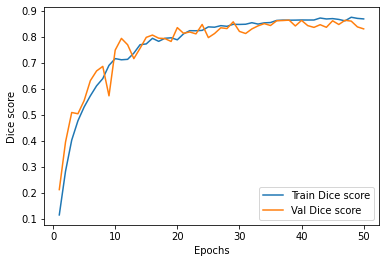

In [90]:
plt.plot(range(1, len(train_dice_loss)+1), [-x for x in train_dice_loss], label="Train Dice score")
plt.plot(range(1, len(val_dice_loss)+1), [-x for x in val_dice_loss], label="Val Dice score")
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Dice score")

Save trained model

In [96]:
PATH = '/content/drive/My Drive/net.pth'
torch.save(model.state_dict(), PATH)

Predicted output on the same slice as earlier

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


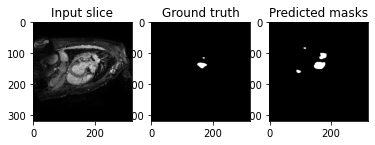

In [105]:
slice_pair = pair.get_pair_slice(42)
input = slice_pair['input']
gt = slice_pair['gt']

plt.subplot(1, 3, 1)
plt.imshow(input, cmap='gray')
plt.title('Input slice')

plt.subplot(1, 3, 2)
plt.imshow(gt, cmap='gray')
plt.title('Ground truth')


pred = model(torch.from_numpy(input).unsqueeze(0).unsqueeze(0).cuda())
plt.subplot(1, 3, 3)
plt.imshow(pred.cpu().detach().squeeze(), cmap='gray')
plt.title('Predicted masks')

plt.show()